# Exploratory Data Analysis

This notebook explores the China Real Estate dataset:
- Data distributions
- Time series patterns
- Seasonality analysis
- Zero transaction patterns
- Sector-wise statistics

In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path('..').resolve()))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data import DatasetPaths, load_all_training_tables, split_month_sector
from src.utils import build_amount_wide

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
# Load data
paths = DatasetPaths(root_dir=str(Path('..').resolve()))
train = load_all_training_tables(paths)
nht = train['new_house_transactions']
nht_aug = split_month_sector(nht)

print(f"Total records: {len(nht_aug)}")
print(f"Unique sectors: {nht_aug['sector_id'].nunique()}")
print(f"Time range: {nht_aug['time'].min()} to {nht_aug['time'].max()} months since 2019-01")
print(f"\nFirst few rows:")
nht_aug.head()

Total records: 5433
Unique sectors: 95
Time range: 0 to 66 months since 2019-01

First few rows:


,month,sector,num_new_house_transactions,area_new_house_transactions,price_new_house_transactions,amount_new_house_transactions,area_per_unit_new_house_transactions,total_price_per_unit_new_house_transactions,num_new_house_available_for_sale,area_new_house_available_for_sale,period_new_house_sell_through,year,month_num,time,sector_id
0,2019-Jan,sector 1,52,4906,28184,13827.14,94,265.91,159.0,15904.0,3.78,2019,1,0,1
1,2019-Jan,sector 2,145,15933,17747,28277.73,110,195.02,1491.0,175113.0,12.29,2019,1,0,2
2,2019-Jan,sector 4,6,725,28004,1424.21,127,356.05,40.0,6826.0,5.95,2019,1,0,4
3,2019-Jan,sector 5,2,212,37432,792.10,106,396.05,161.0,17173.0,83.95,2019,1,0,5
4,2019-Jan,sector 6,5,773,15992,607.94,95,151.99,189.0,19696.0,14.27,2019,1,0,6


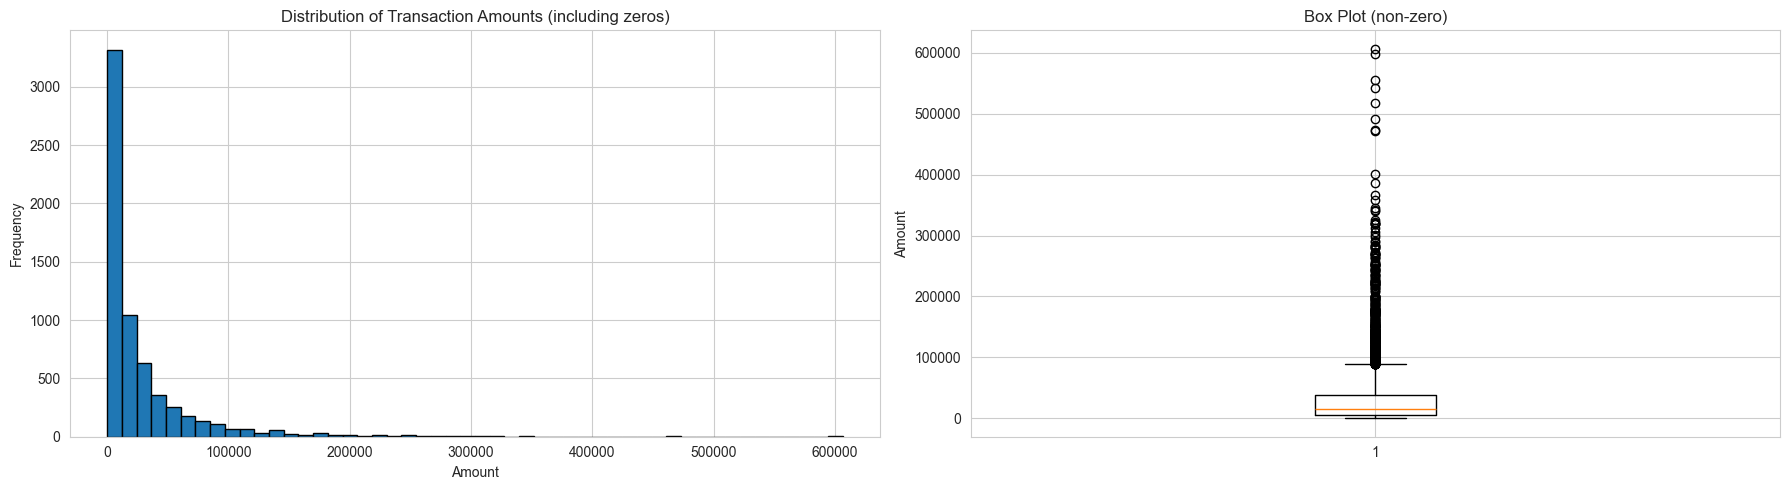

Transaction Amount Statistics
count      6432.000000
mean      27526.152220
std       46597.345676
min           0.000000
25%        1569.280000
50%       11254.130000
75%       32417.022500
max      606407.640000
dtype: float64


In [ ]:
# Distribution of target variable
# Build full matrix with zeros
amount = build_amount_wide(nht)
all_values = amount.values.flatten()

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Histogram
axes[0].hist(all_values, bins=50, edgecolor='black')
axes[0].set_title('Distribution of Transaction Amounts (including zeros)')
axes[0].set_xlabel('Amount')
axes[0].set_ylabel('Frequency')

non_zero = all_values[all_values > 0]

# Box plot
axes[1].boxplot(non_zero, vert=True)
axes[1].set_title('Box Plot (non-zero)')
axes[1].set_ylabel('Amount')

plt.tight_layout()
plt.show()

print("Transaction Amount Statistics")
print(pd.Series(all_values).describe())

CSV rows (non-zero only): 5433
Full matrix cells: 6432
Zero cells: 999
Zero rate: 15.53%


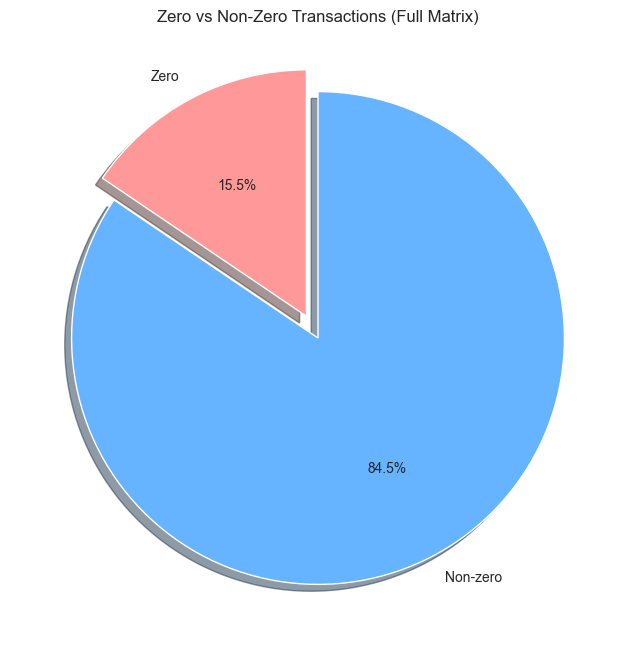

In [ ]:
# Zero transaction analysis - CRITICAL!
# The CSV only contains non-zero transactions
# But the full dataset has 67 months × 96 sectors = 6,432 combinations
# Missing rows = zero transactions!

from src.utils import build_amount_wide

# Build full matrix with zeros
amount = build_amount_wide(nht)
total_cells = amount.shape[0] * amount.shape[1]
zero_cells = (amount == 0).sum().sum()
zero_rate = zero_cells / total_cells

print(f"CSV rows (non-zero only): {len(nht)}")
print(f"Full matrix cells: {total_cells}")
print(f"Zero cells: {zero_cells}")
print(f"Zero rate: {zero_rate:.2%}")

# Pie chart
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
labels = ['Zero', 'Non-zero']
sizes = [zero_cells, total_cells - zero_cells]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)

ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=90)
ax.set_title('Zero vs Non-Zero Transactions (Full Matrix)')
plt.show()

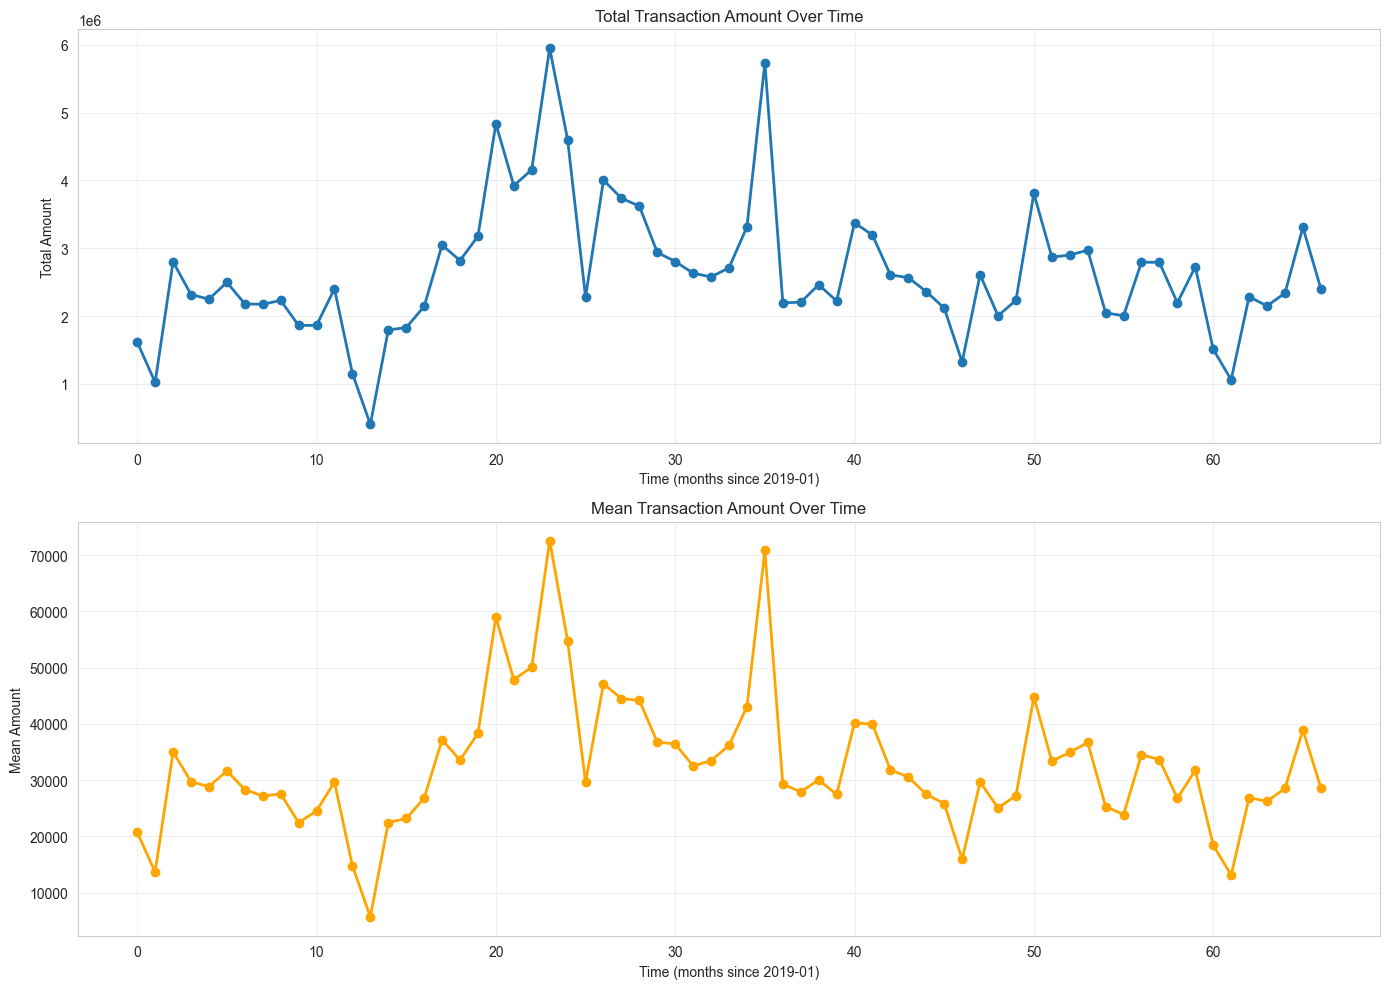

In [ ]:
# Time series: Total transactions over time
monthly_total = nht_aug.groupby('time')['amount_new_house_transactions'].agg(['sum', 'mean', 'count']).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].plot(monthly_total['time'], monthly_total['sum'], marker='o', linewidth=2)
axes[0].set_title('Total Transaction Amount Over Time')
axes[0].set_xlabel('Time (months since 2019-01)')
axes[0].set_ylabel('Total Amount')
axes[0].grid(True, alpha=0.3)

axes[1].plot(monthly_total['time'], monthly_total['mean'], marker='o', linewidth=2, color='orange')
axes[1].set_title('Mean Transaction Amount Over Time')
axes[1].set_xlabel('Time (months since 2019-01)')
axes[1].set_ylabel('Mean Amount')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

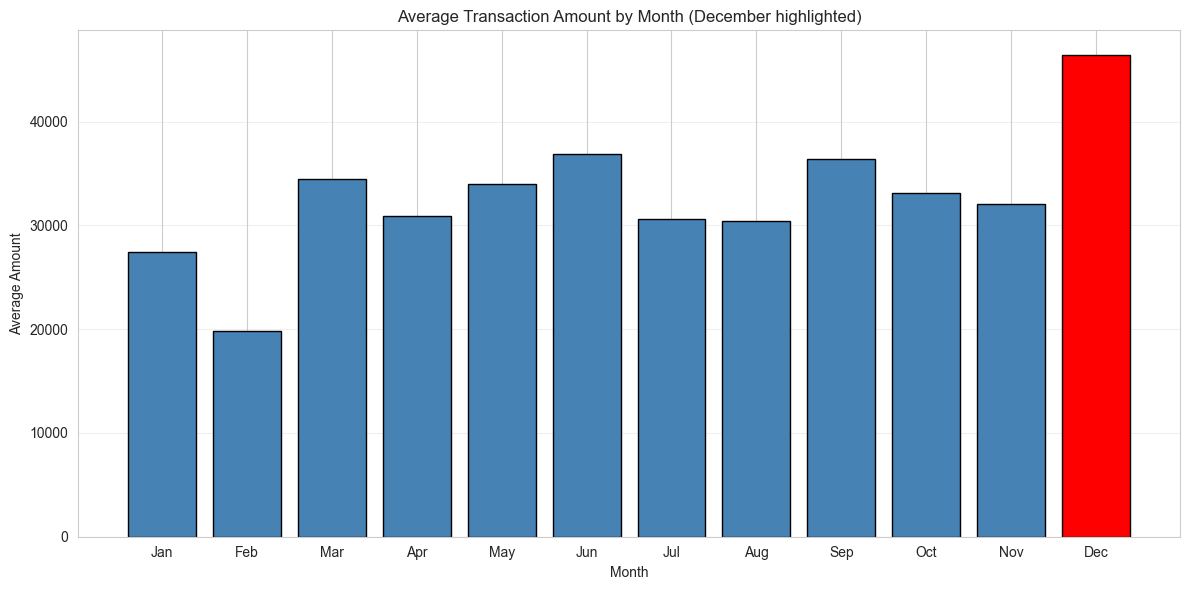


December average: 46470
Non-December average: 31464


In [ ]:
# Seasonality analysis: Month-of-year patterns
monthly_avg = nht_aug.groupby('month_num')['amount_new_house_transactions'].mean().reset_index()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.bar(monthly_avg['month_num'], monthly_avg['amount_new_house_transactions'], 
       color=['red' if m == 12 else 'steelblue' for m in monthly_avg['month_num']], 
       edgecolor='black')
ax.set_title('Average Transaction Amount by Month (December highlighted)')
ax.set_xlabel('Month')
ax.set_ylabel('Average Amount')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"\nDecember average: {monthly_avg[monthly_avg['month_num']==12]['amount_new_house_transactions'].values[0]:.0f}")
print(f"Non-December average: {monthly_avg[monthly_avg['month_num']!=12]['amount_new_house_transactions'].mean():.0f}")

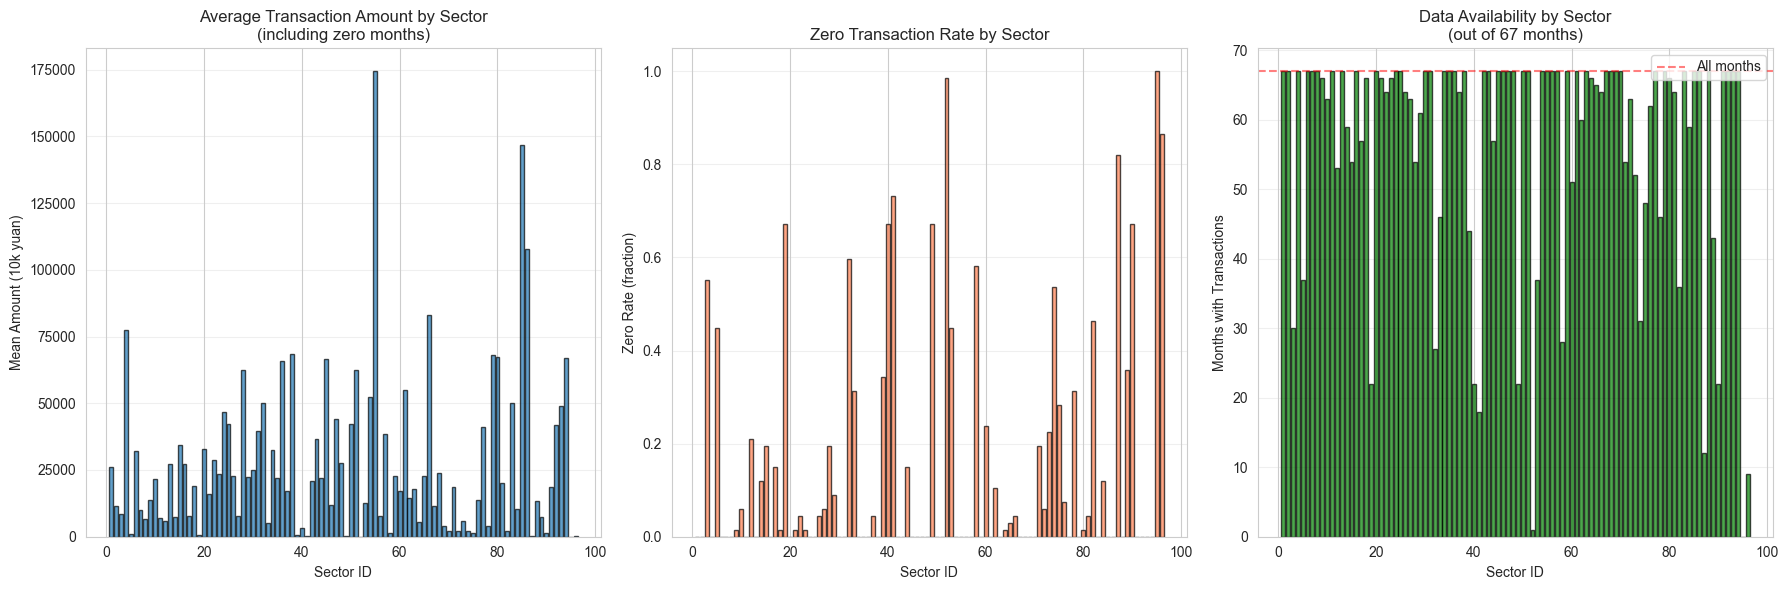


=== Sector Statistics Summary ===
Total sectors: 96

Top 5 sectors by average amount:
           sector_id           mean  zero_rate  months_with_data
sector_id                                                       
55                55  174430.817313   0.000000                67
85                85  146959.251493   0.000000                67
86                86  107669.147164   0.000000                67
66                66   83065.402537   0.044776                64
4                  4   77294.720896   0.000000                67

Top 5 sectors by zero rate (most dormant):
           sector_id        mean  zero_rate  months_with_data
sector_id                                                    
95                95    0.000000   1.000000                 0
52                52   21.807015   0.985075                 1
96                96  111.585373   0.865672                 9
87                87   91.330149   0.820896                12
41                41  174.785821   0.73134

: 

In [ ]:
# Sector-wise statistics (including zeros from full matrix)
amount = build_amount_wide(nht)

# Calculate per-sector statistics from full matrix
sector_stats = pd.DataFrame({
    'sector_id': range(1, 97),
    'mean': amount.mean(axis=0),
    'std': amount.std(axis=0),
    'min': amount.min(axis=0),
    'max': amount.max(axis=0),
    'zero_rate': (amount == 0).mean(axis=0),
    'months_with_data': (amount > 0).sum(axis=0)
})

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Mean by sector
axes[0].bar(sector_stats['sector_id'], sector_stats['mean'], edgecolor='black', alpha=0.7)
axes[0].set_title('Average Transaction Amount by Sector\n(including zero months)')
axes[0].set_xlabel('Sector ID')
axes[0].set_ylabel('Mean Amount (10k yuan)')
axes[0].grid(True, alpha=0.3, axis='y')

# Zero rate by sector
axes[1].bar(sector_stats['sector_id'], sector_stats['zero_rate'], color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('Zero Transaction Rate by Sector')
axes[1].set_xlabel('Sector ID')
axes[1].set_ylabel('Zero Rate (fraction)')
axes[1].grid(True, alpha=0.3, axis='y')

# Months with data by sector
axes[2].bar(sector_stats['sector_id'], sector_stats['months_with_data'], color='green', edgecolor='black', alpha=0.7)
axes[2].set_title('Data Availability by Sector\n(out of 67 months)')
axes[2].set_xlabel('Sector ID')
axes[2].set_ylabel('Months with Transactions')
axes[2].axhline(y=67, color='red', linestyle='--', alpha=0.5, label='All months')
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n=== Sector Statistics Summary ===")
print(f"Total sectors: {len(sector_stats)}")
print(f"\nTop 5 sectors by average amount:")
print(sector_stats.nlargest(5, 'mean')[['sector_id', 'mean', 'zero_rate', 'months_with_data']])
print(f"\nTop 5 sectors by zero rate (most dormant):")
print(sector_stats.nlargest(5, 'zero_rate')[['sector_id', 'mean', 'zero_rate', 'months_with_data']])
print(f"\nSectors with full data (67 months):")
full_data_sectors = sector_stats[sector_stats['months_with_data'] == 67]
print(f"Count: {len(full_data_sectors)}")
print(f"\nSectors with < 30 months of data:")
sparse_sectors = sector_stats[sector_stats['months_with_data'] < 30]
print(sparse_sectors[['sector_id', 'months_with_data', 'zero_rate']])

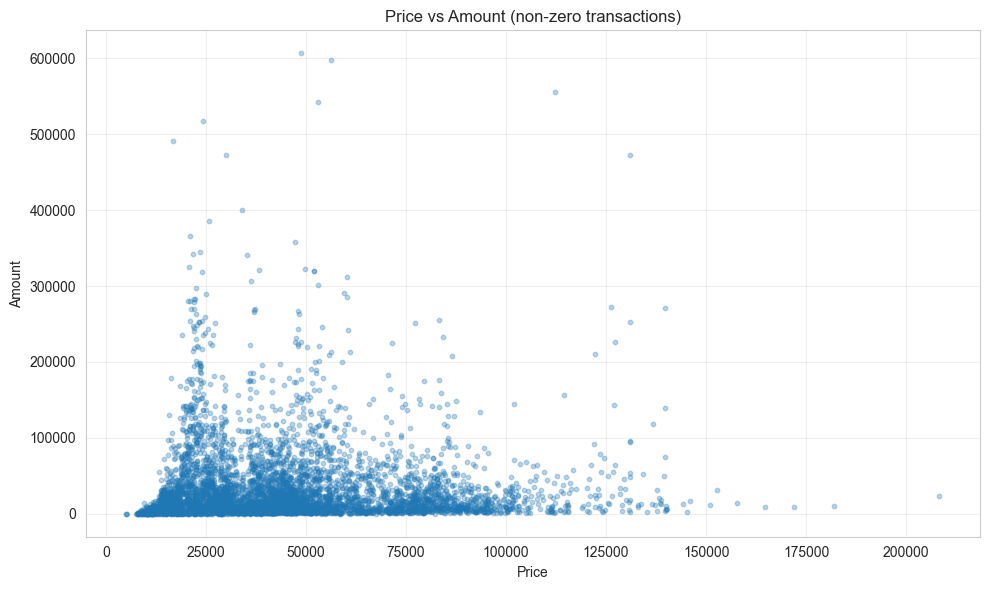


Correlation: 0.015


In [ ]:
# Correlation: price vs amount
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
non_zero_data = nht_aug[nht_aug['amount_new_house_transactions'] > 0]
ax.scatter(non_zero_data['price_new_house_transactions'], 
           non_zero_data['amount_new_house_transactions'], 
           alpha=0.3, s=10)
ax.set_title('Price vs Amount (non-zero transactions)')
ax.set_xlabel('Price')
ax.set_ylabel('Amount')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

corr = non_zero_data[['price_new_house_transactions', 'amount_new_house_transactions']].corr()
print(f"\nCorrelation: {corr.iloc[0, 1]:.3f}")

## Key Findings

1. **Zero Transactions**: 15.5% of sector-months have no activity - critical for metric (predicting non-zero when actual=0 causes APE explosion)

2. **December Seasonality**: Strong 30%+ boost in December across all years - most predictable pattern in the data

3. **Right-Skewed Distribution**: Mean (27,526) >> Median (11,254) - geometric mean outperforms arithmetic mean

4. **High Sector Heterogeneity**: Activity ranges from 0 to 67 months per sector - sector-specific modeling needed

5. **Limited Data**: Average 57 months per sector - simple models preferred over complex ones to avoid overfitting

6. **Key Strategy**: Zero guard (predict 0 if recent zeros exist) + geometric mean + December boost = winning combination